# DSCI 503 – Project 04
### Sean Kilfoy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Part 1: Loading the Dataset; Preliminary Analysis

In this section, I will load the data into a DataFrame and explore the structure of the data set.

In [2]:
fc = pd.read_csv('forest_cover.txt', sep='\t')
fc.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,Rawah,29,5
1,2590,56,2,212,-6,390,220,235,151,6225,Rawah,29,5
2,2804,139,9,268,65,3180,234,238,135,6121,Rawah,12,2
3,2785,155,18,242,118,3090,238,238,122,6211,Rawah,30,2
4,2595,45,2,153,-1,391,220,234,150,6172,Rawah,29,5


Displaying the shape of the dataset tells me that it has 15,120 instances and 13 features.

In [3]:
fc.shape

(15120, 13)

Following is the distribution of cover types in the datasets.

In [4]:
fc['Cover_Type'].value_counts().sort_index()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

Below is a color palette for plots I will create later in this project.

In [5]:
palette = [
    'orchid',
    'lightcoral',
    'orange',
    'gold',
    'lightgreen',
    'deepskyblue',
    'cornflowerblue'
]

## Part 2: Distribution of Cover Type by Wilderness Area
In this part, I will determine the distribution of wilderness areas within the dataset and create a DataFrame that determines how many regions of each cover type are in each of the four wilderness areas.

Below is the distribution of the wilderness areas within the dataset:

In [6]:
fc['Wilderness_Area'].value_counts().sort_index()

Cache la Poudre    4675
Comanche Peak      6349
Neota               499
Rawah              3597
Name: Wilderness_Area, dtype: int64

Below is a DataFrame displaying the number of regions of each cover type that are in each of the four wilderness areas.

In [7]:
ct_by_wa = pd.crosstab(fc['Cover_Type'], fc['Wilderness_Area'])
ct_by_wa

Wilderness_Area,Cache la Poudre,Comanche Peak,Neota,Rawah
Cover_Type,,,,
1,0,917,181,1062
2,20,940,66,1134
3,1297,863,0,0
4,2160,0,0,0
5,0,1304,0,856
6,1198,962,0,0
7,0,1363,252,545


Following is a stacked bar chart representing the above data.

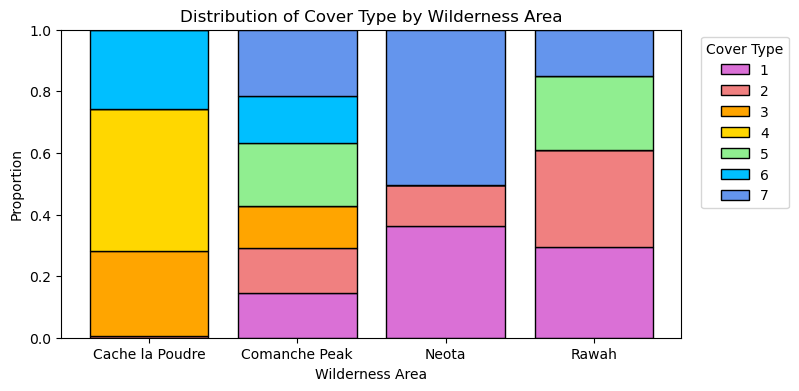

In [8]:
ct_by_wa_props = ct_by_wa / ct_by_wa.sum()
bb = np.cumsum(ct_by_wa_props) - ct_by_wa_props
fig = plt.figure(figsize=[8, 4])
for i, row in ct_by_wa_props.iterrows():
    plt.bar(
        ct_by_wa_props.columns,
        row,
        bottom=bb.loc[i],
        edgecolor='black',
        color=palette[i-1],
        label=i
    )
plt.xlabel('Wilderness Area')
plt.ylabel('Proportion')
plt.title('Distribution of Cover Type by Wilderness Area')
plt.legend(
    title='Cover Type',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.show()

## Part 3: Distribution of Cover Type by Soil Type
In this section, I explore the relationship between cover type and soil type. I start by creating a DataFrame to determine the how many regions of each cover type there are for each of the 40 soil types.

In [9]:
ct_by_st = pd.crosstab(fc['Cover_Type'], fc['Soil_Type'])
ct_by_st

Soil_Type,1,2,3,4,5,6,8,9,10,11,...,31,32,33,34,35,36,37,38,39,40
Cover_Type,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,0,1,9,5,...,114,230,184,0,3,0,0,80,79,49
2,0,3,12,20,0,7,1,9,81,67,...,97,255,184,12,1,2,0,7,3,3
3,121,283,133,462,55,248,0,0,717,89,...,0,5,0,0,0,0,0,0,0,0
4,139,94,799,133,39,244,0,0,170,24,...,0,0,0,0,0,0,0,0,0,0
5,0,61,0,129,0,0,0,0,64,154,...,87,100,115,4,0,0,0,0,0,0
6,95,182,18,87,71,151,0,0,1101,67,...,7,30,66,2,0,0,0,0,0,0
7,0,0,0,7,0,0,0,0,0,0,...,27,70,67,4,98,8,34,641,575,407


Below is a stacked bar chart representation of the above data.

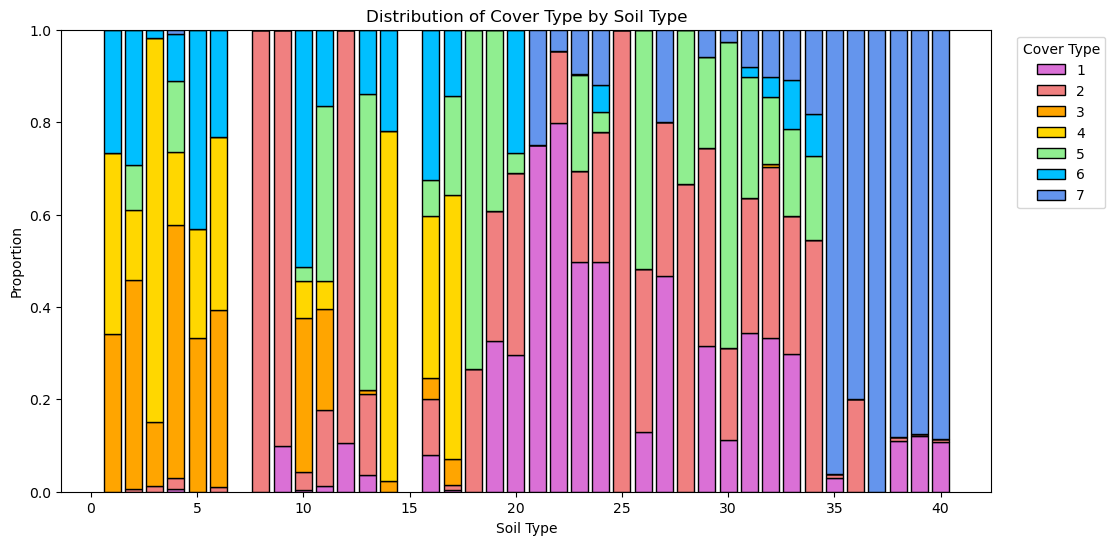

In [10]:
ct_by_st_props = ct_by_st / ct_by_st.sum()
bb = np.cumsum(ct_by_st_props) - ct_by_st_props
fig = plt.figure(figsize=[12,6])
for i, row in ct_by_st_props.iterrows():
    plt.bar(
        ct_by_st_props.columns,
        row,
        bottom=bb.loc[i],
        edgecolor='black',
        color=palette[i-1],
        label=i
    )
plt.xlabel('Soil Type')
plt.ylabel('Proportion')
plt.title('Distribution of Cover Type by Soil Type')
plt.legend(
    title='Cover Type',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.show()

## Part 4: Distribution of Elevation by Cover Type
In this section, I explore the relationship between cover type and elevation. I start by calculating the average elevation for each of the seven cover types.

In [11]:
elev_by_ct = fc[['Elevation', 'Cover_Type']].groupby('Cover_Type').mean()
elev_by_ct

,Elevation
Cover_Type,
1,3128.025926
2,2922.540278
3,2398.423148
4,2223.420370
5,2786.801389
6,2423.276852
7,3362.769907


Below are histograms displaying the relationship between cover type and elevation.

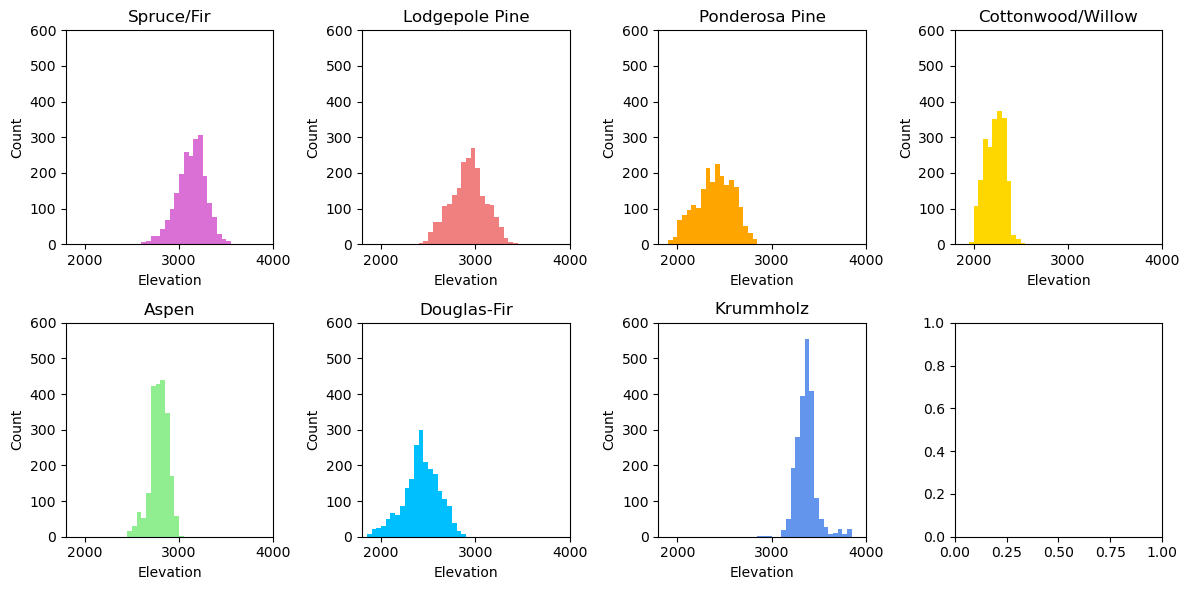

In [12]:
cover_type_names = {
    1: 'Spruce/Fir',
    2: 'Lodgepole Pine',
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas-Fir',
    7: 'Krummholz'
}
fig, axs = plt.subplots(2, 4, figsize=[12,6])
for i, ax in enumerate(axs.flat):
    if i < 7:
        ct = i+1
        elev = fc.loc[fc['Cover_Type']==ct, 'Elevation']
        ax.hist(
            elev,
            bins=np.arange(1800, 4050, 50),
            color=palette[ct-1]
        )
        ax.set_title(cover_type_names[ct])
        ax.set_xlim([1800, 4000])
        ax.set_ylim([0, 600])
        ax.set_xlabel('Elevation')
        ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

## Part 5: Creating Training, Validation, and Test Sets
In this part, I encode categorical variables and create training, validation, and test sets using the Forest Cover data. I start by separating the categorical features, numerical features, and labels.

In [13]:
X_num = fc[[
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
    'Soil_Type',
    'Cover_Type'
]].values
X_cat = fc[[
    'Wilderness_Area'
]].values
y = fc['Cover_Type'].values
print(f"Numerical Feature Array Shape:   {X_num.shape}")
print(f"Categorical Feature Array Shape: {X_cat.shape}")
print(f"Label Array Shape:               {y.shape}")

Numerical Feature Array Shape:   (15120, 12)
Categorical Feature Array Shape: (15120, 1)
Label Array Shape:               (15120,)


Encode the categorical variables with one-hot encoding.

In [14]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(X_cat)
X_enc = encoder.transform(X_cat)
print(f"Encoded Feature Array Shape: {X_enc.shape}")

Encoded Feature Array Shape: (15120, 4)


Combine the numerical features with the encoded features.

In [15]:
X = np.hstack((X_num, X_enc))
print(f"Feature Array Shape: {X.shape}")

Feature Array Shape: (15120, 16)


Split the data into training, validation, and test sets, using a 70/15/15
split.

In [16]:
X_train, X_hold, y_train, y_hold = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=1,
    stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_hold,
    y_hold,
    test_size=0.5,
    random_state=1,
    stratify=y_hold
)
print(f'Training Features Shape:   {X_train.shape}')
print(f'Validation Features Shape: {X_valid.shape}')
print(f'Test Features Shape:       {X_test.shape}')

Training Features Shape:   (10584, 16)
Validation Features Shape: (2268, 16)
Test Features Shape:       (2268, 16)


## Part 6: Logistic Regression Model
In this section, I create and evaluate a logistic regression model. With a little time to spare, I came back and greatly increased the max_iter value to see if I could get close to the decision tree's accuracy of 1.000. This run takes about a minute and still doesn't converge, while the decision tree shows a perfect model with a depth of only 5.

In [17]:
lr_mod = LogisticRegression(
    penalty='none',
    solver='lbfgs',
    max_iter=28888,
    multi_class='multinomial'
)
lr_mod.fit(X_train, y_train)
train_acc = lr_mod.score(X_train, y_train)
val_acc = lr_mod.score(X_valid, y_valid)
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy:   0.9828
Validation Accuracy: 0.9877


/Users/seankilfoy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Part 7: Decision Tree Models
In this part, I will create and evaluate several decision tree models. 

In [18]:
dt_train_acc = []
dt_valid_acc = []
depth_range = range(2, 31)
for depth in depth_range:
    np.random.seed(1)
    temp_tree = DecisionTreeClassifier(max_depth=depth)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    dt_valid_acc.append(temp_tree.score(X_valid, y_valid))
dt_idx = np.argmax(dt_valid_acc)
dt_opt_depth = depth_range[dt_idx]
dt_opt_train_acc = dt_train_acc[dt_idx]
dt_opt_valid_acc = dt_valid_acc[dt_idx]
print(f"Optimal value for max_depth:           {dt_opt_depth}")
print(f"Training Accuracy for Optimal Model:   {dt_opt_train_acc:.4f}")
print(f"Validation Accuracy for Optimal Model: {dt_opt_valid_acc:.4f}")

Optimal value for max_depth:           5
Training Accuracy for Optimal Model:   1.0000
Validation Accuracy for Optimal Model: 1.0000


Below is a plot of the training and validation curves.

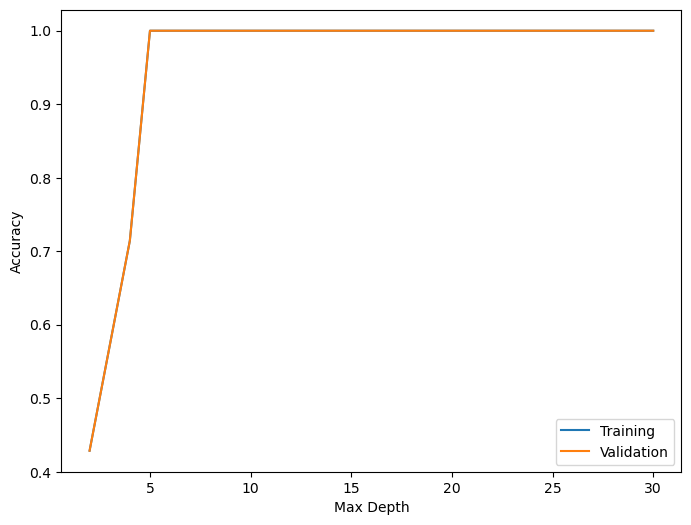

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(depth_range, dt_train_acc, label="Training")
plt.plot(depth_range, dt_valid_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Part 8: Random Forest Models
In this part, I will create and evaluate several random forest models. 

In [20]:
rf_train_acc = []
rf_valid_acc = []
for depth in depth_range:
    np.random.seed(1)
    temp_forest = RandomForestClassifier(
        max_depth=depth,
        n_estimators=100
    )
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))
    rf_valid_acc.append(temp_forest.score(X_valid, y_valid))
rf_idx = np.argmax(rf_valid_acc)
rf_opt_depth = depth_range[rf_idx]
rf_opt_train_acc = rf_train_acc[rf_idx]
rf_opt_valid_acc = rf_valid_acc[rf_idx]
print(f"Optimal value for max_depth:           {rf_opt_depth}")
print(f"Training Accuracy for Optimal Model:   {rf_opt_train_acc:.4f}")
print(f"Validation Accuracy for Optimal Model: {rf_opt_valid_acc:.4f}")

Optimal value for max_depth:           10
Training Accuracy for Optimal Model:   1.0000
Validation Accuracy for Optimal Model: 0.9996


Below is a plot of the above accuracy data.

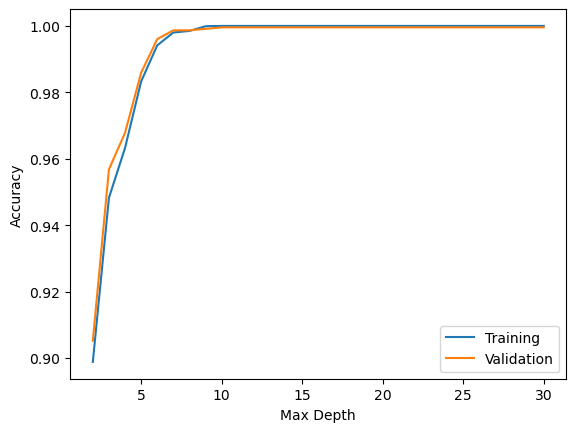

In [21]:
plt.plot(depth_range, rf_train_acc, label='Training')
plt.plot(depth_range, rf_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Part 9: Create and Evaluate Final Model
Since the decision tree model gave me the best performance on the validation set (1.000), I will use it for my final model and evaluate it on the test set.

In [22]:
np.random.seed(1)
final_model = DecisionTreeClassifier(max_depth=5)
final_model.fit(X_train, y_train)
train_acc = final_model.score(X_train, y_train)
valid_acc = final_model.score(X_valid, y_valid)
test_acc = final_model.score(X_test, y_test)
print(f"Training Accuracy for Final Model:   {train_acc:.4f}")
print(f"Validation Accuracy for Final Model: {valid_acc:.4f}")
print(f"Testing Accuracy for Final Model:    {test_acc:.4f}")

Training Accuracy for Final Model:   1.0000
Validation Accuracy for Final Model: 1.0000
Testing Accuracy for Final Model:    1.0000


Following is a confusion matrix detailing the model's performance on the test set.

In [23]:
test_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, test_pred)
cm_df = pd.DataFrame(
    cm,
    index=range(1,8),
    columns=range(1,8)
)
print("Confusion Matrix:")
print("-----------------")
cm_df

Confusion Matrix:
-----------------


,1,2,3,4,5,6,7
1,324,0,0,0,0,0,0
2,0,324,0,0,0,0,0
3,0,0,324,0,0,0,0
4,0,0,0,324,0,0,0
5,0,0,0,0,324,0,0
6,0,0,0,0,0,324,0
7,0,0,0,0,0,0,324


Finally, a classification report provides further insight into the model's performance on the test set.

In [24]:
print("Classification Report:")
print("----------------------")
print()
print("              ---------------------------------------")
print(classification_report(y_test, test_pred))
print("-----------------------------------------------------")

Classification Report:
----------------------

              ---------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       324
           2       1.00      1.00      1.00       324
           3       1.00      1.00      1.00       324
           4       1.00      1.00      1.00       324
           5       1.00      1.00      1.00       324
           6       1.00      1.00      1.00       324
           7       1.00      1.00      1.00       324

    accuracy                           1.00      2268
   macro avg       1.00      1.00      1.00      2268
weighted avg       1.00      1.00      1.00      2268

-----------------------------------------------------
